# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the data

In [2]:
root = "data_final_project/KuaiRec 2.0/data/"
train_data = pd.read_parquet("./exports/train_data.pq")
test_data = pd.read_parquet("./exports/test_data.pq")

In [3]:
all_data_df = pd.concat([train_data, test_data], ignore_index=True)

# Data Analysis

### Analysis of Interaction Repartition

/tmp/ipykernel_66770/4162679477.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=all_data_df["user_id"].value_counts(), bins=50, palette="icefire")


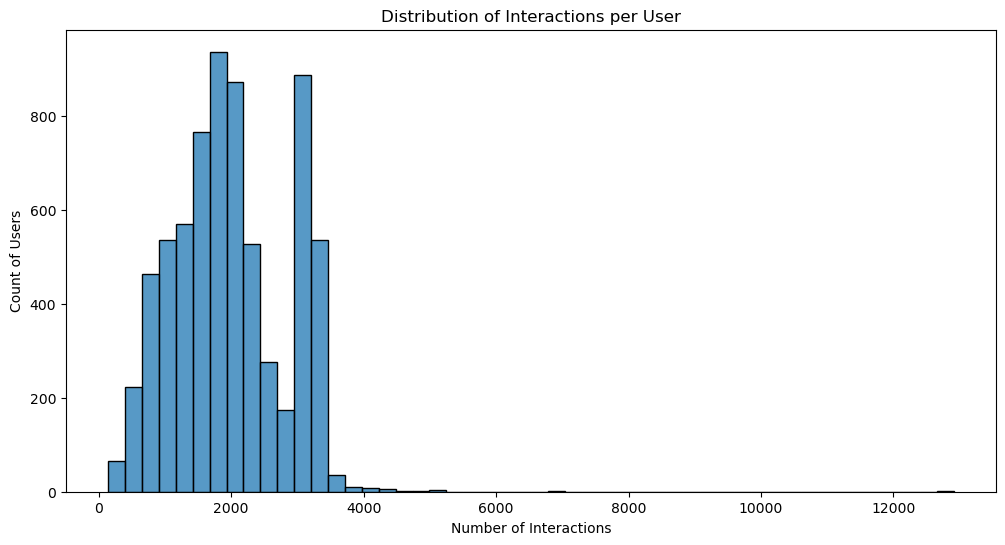

/tmp/ipykernel_66770/4162679477.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=all_data_df["video_id"].value_counts(), bins=50, log=True, palette="icefire")


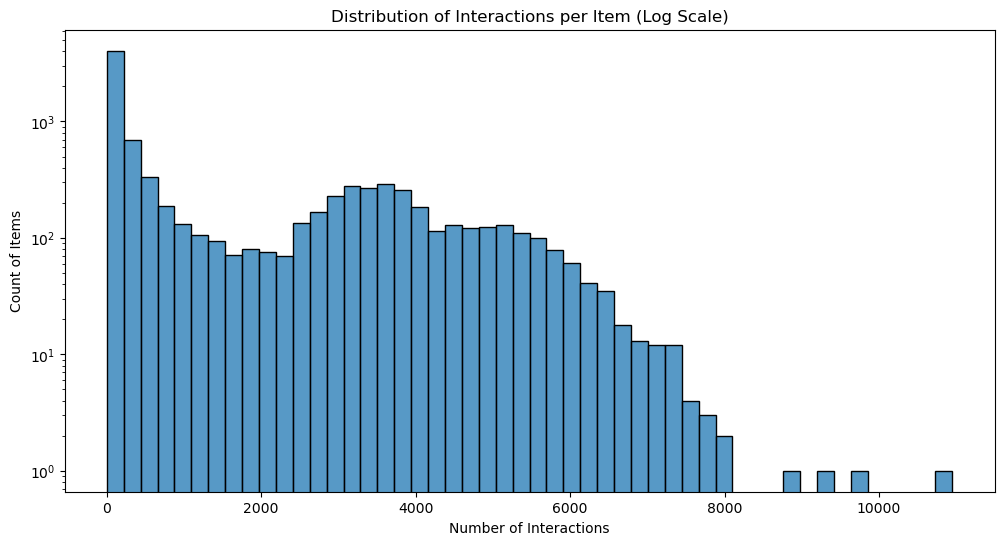

In [4]:
plt.figure(figsize=(12, 6))
sns.histplot(data=all_data_df["user_id"].value_counts(), bins=50, palette="icefire")
plt.title("Distribution of Interactions per User")
plt.xlabel("Number of Interactions")
plt.ylabel("Count of Users")
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=all_data_df["video_id"].value_counts(), bins=50, log=True, palette="icefire")
plt.title("Distribution of Interactions per Item (Log Scale)")
plt.xlabel("Number of Interactions")
plt.ylabel("Count of Items")
plt.show()

### Analysis of Temporal Activity

/tmp/ipykernel_66770/806282985.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=to_plot.index, y=to_plot.values, palette="icefire")


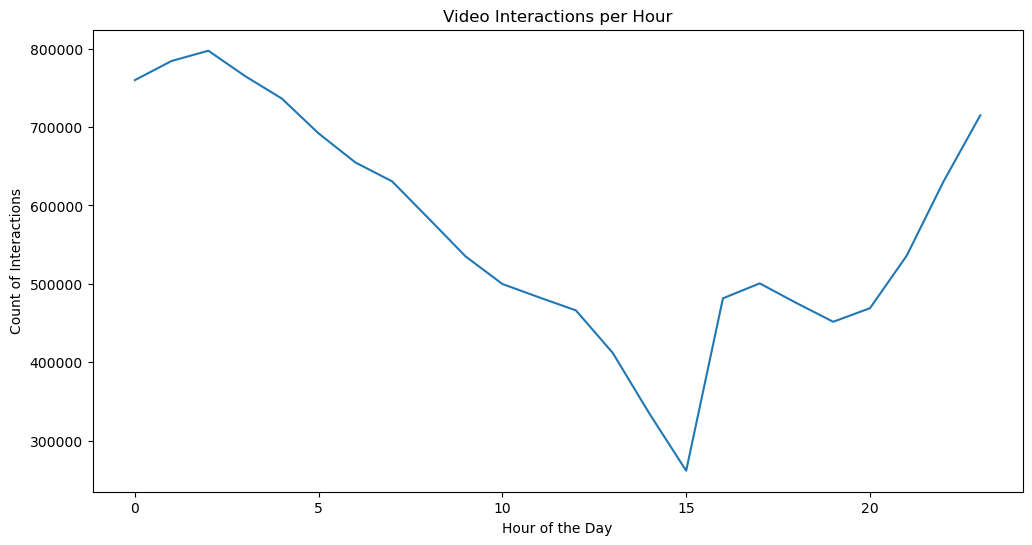

/tmp/ipykernel_66770/806282985.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=days, y=to_plot.values, palette="icefire")


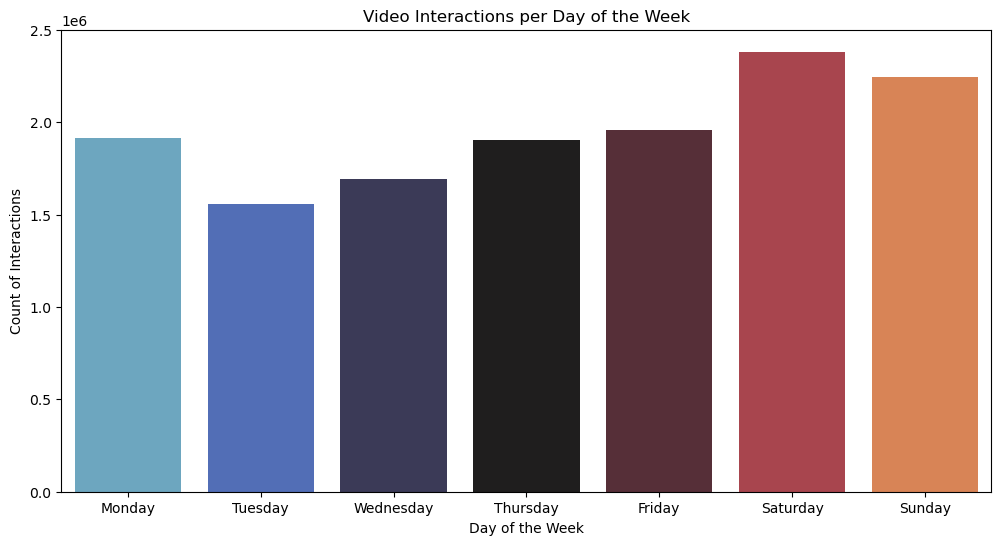

In [5]:
all_data_df["hour"] = all_data_df["timestamp"].dt.hour
all_data_df["weekday"] = all_data_df["timestamp"].dt.dayofweek

to_plot = all_data_df.groupby("hour").size()
plt.figure(figsize=(12, 6))
sns.lineplot(x=to_plot.index, y=to_plot.values, palette="icefire")
plt.title("Video Interactions per Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Count of Interactions")
plt.show()

to_plot = all_data_df.groupby("weekday").size()
plt.figure(figsize=(12, 6))
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.barplot(x=days, y=to_plot.values, palette="icefire")
plt.title("Video Interactions per Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Count of Interactions")
plt.show()

### Analysis of User Active Degree and Implications

/tmp/ipykernel_66770/3526657732.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=to_plot.index, y=to_plot.values, order=to_plot.index, palette="icefire")


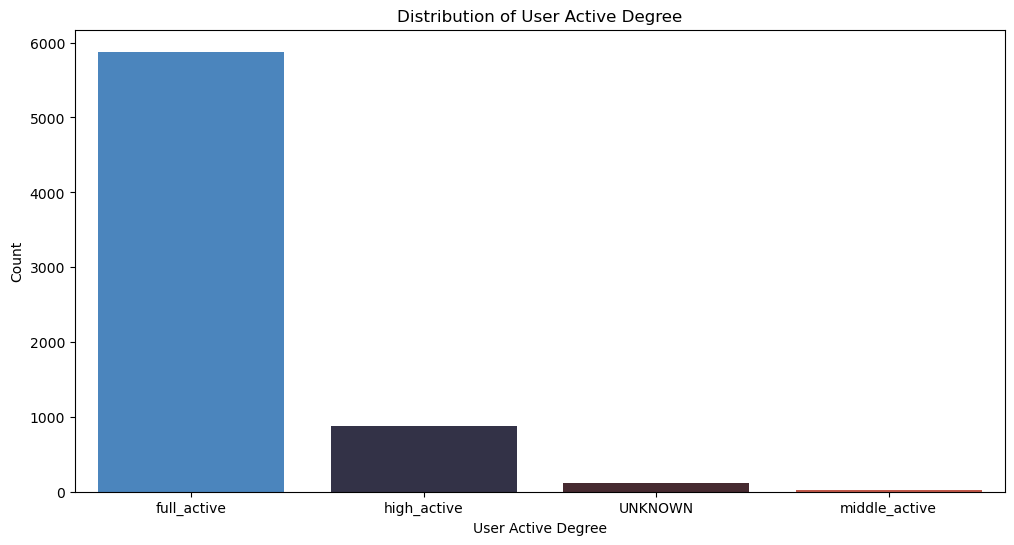

/tmp/ipykernel_66770/3526657732.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=to_plot.index, y=to_plot.values, order=to_plot.index, palette="icefire")


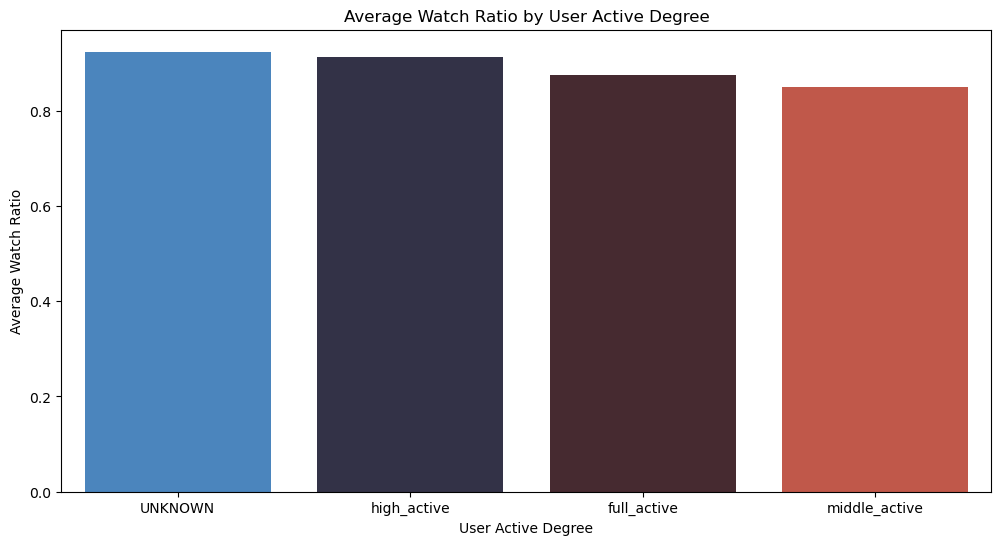

In [6]:
to_plot = all_data_df.groupby("user_active_degree")["user_id"].nunique().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=to_plot.index, y=to_plot.values, order=to_plot.index, palette="icefire")
plt.title("Distribution of User Active Degree")
plt.xlabel("User Active Degree")
plt.ylabel("Count")
plt.show()

to_plot = all_data_df.groupby("user_active_degree")["watch_ratio"].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=to_plot.index, y=to_plot.values, order=to_plot.index, palette="icefire")
plt.title("Average Watch Ratio by User Active Degree")
plt.xlabel("User Active Degree")
plt.ylabel("Average Watch Ratio")
plt.show()

### Analysis of Video Categories

/tmp/ipykernel_66770/1487551764.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=to_plot, y="first_level_category_id", order=to_plot["first_level_category_id"].value_counts().index, palette="icefire")


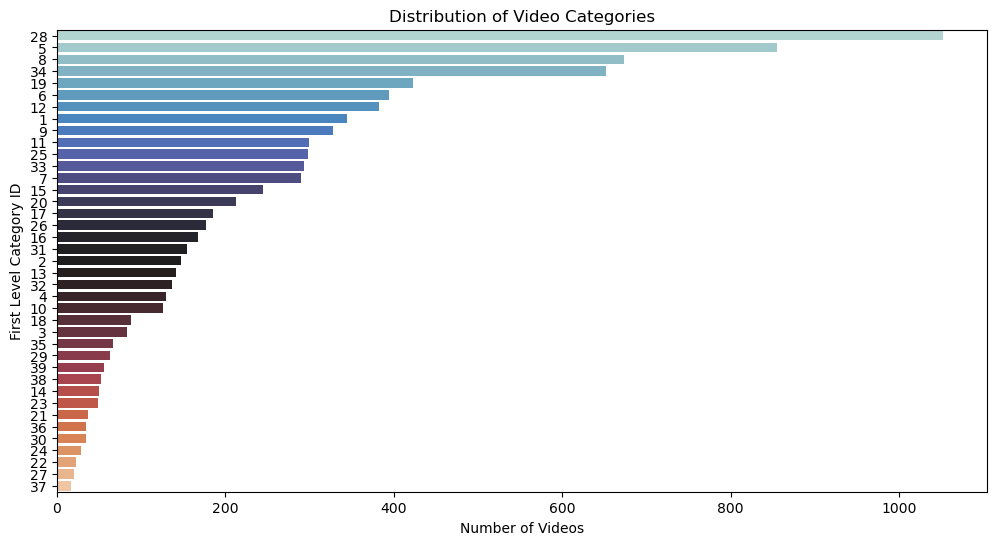

/tmp/ipykernel_66770/1487551764.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=to_plot, y="first_level_category_id", x="video_duration", orient="h", order=to_plot.sort_values("video_duration", ascending=False)["first_level_category_id"], palette="icefire")


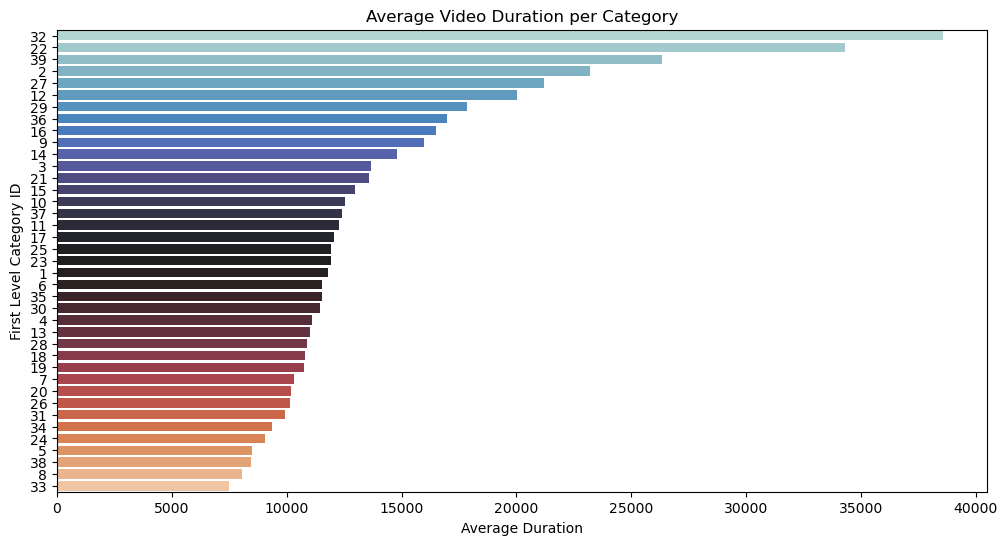

/tmp/ipykernel_66770/1487551764.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=to_plot, y="first_level_category_id", x="mean", orient="h", order=to_plot.index, palette="icefire")


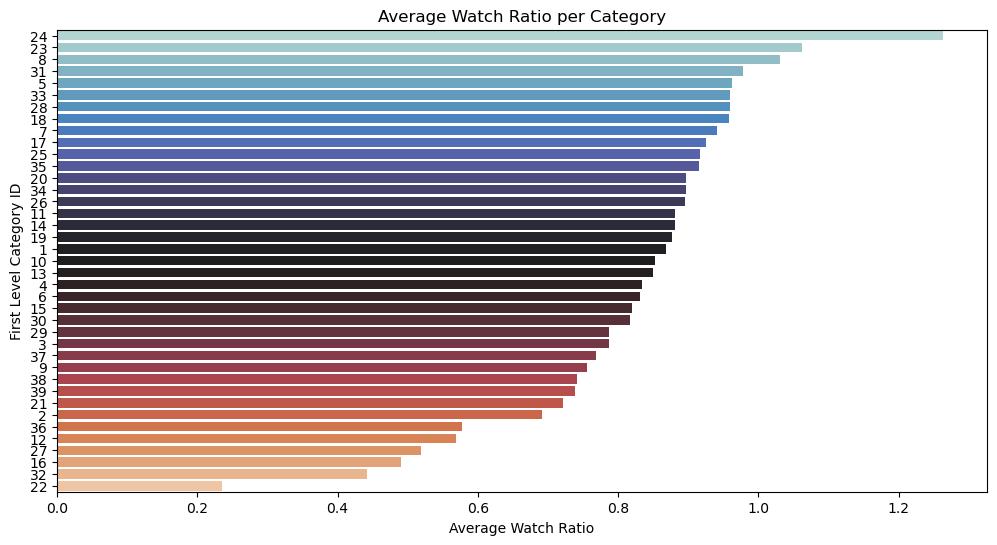

In [7]:
to_plot = all_data_df.drop_duplicates(subset="video_id")[["video_id", "first_level_category_id"]]
plt.figure(figsize=(12, 6))
sns.countplot(data=to_plot, y="first_level_category_id", order=to_plot["first_level_category_id"].value_counts().index, palette="icefire")
plt.title("Distribution of Video Categories")
plt.xlabel("Number of Videos")
plt.ylabel("First Level Category ID")
plt.show()

to_plot = all_data_df.drop_duplicates(subset="video_id").groupby("first_level_category_id")["video_duration"].mean().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=to_plot, y="first_level_category_id", x="video_duration", orient="h", order=to_plot.sort_values("video_duration", ascending=False)["first_level_category_id"], palette="icefire")
plt.title("Average Video Duration per Category")
plt.xlabel("Average Duration")
plt.ylabel("First Level Category ID")
plt.show()

to_plot = all_data_df.groupby('first_level_category_id')['watch_ratio'].agg(['mean', 'count']).sort_values("mean", ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(data=to_plot, y="first_level_category_id", x="mean", orient="h", order=to_plot.index, palette="icefire")
plt.title("Average Watch Ratio per Category")
plt.xlabel("Average Watch Ratio")
plt.ylabel("First Level Category ID")
plt.show()

### Analysis on watch ratio

/tmp/ipykernel_66770/3011518777.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=to_plot, bins=50, kde=True, palette="icefire")


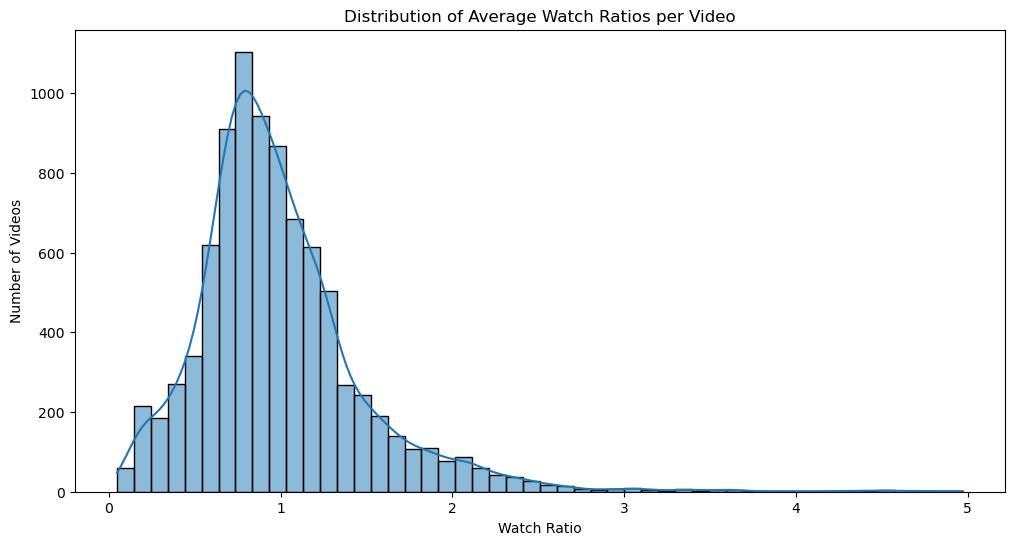

/tmp/ipykernel_66770/3011518777.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=to_plot, x="video_duration", y="watch_ratio", alpha=0.5, palette="icefire")


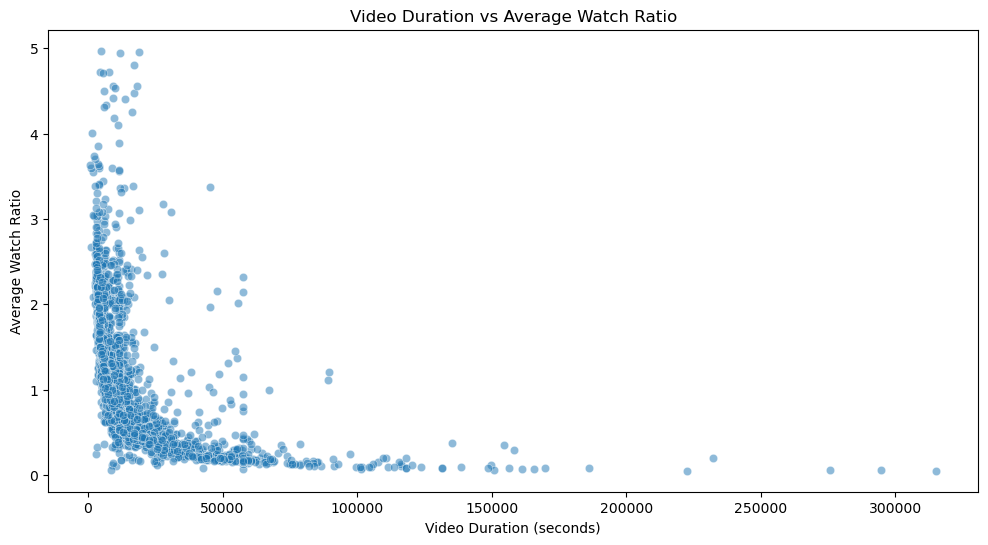

In [9]:
to_plot = all_data_df.groupby("video_id")["watch_ratio"].mean()
plt.figure(figsize=(12, 6))
sns.histplot(data=to_plot, bins=50, kde=True, palette="icefire")
plt.title("Distribution of Average Watch Ratios per Video")
plt.xlabel("Watch Ratio")
plt.ylabel("Number of Videos")
plt.show()

to_plot = all_data_df.groupby("video_id").agg({"video_duration": "first", "watch_ratio": "mean"}).reset_index()
plt.figure(figsize=(12, 6))
sns.scatterplot(data=to_plot, x="video_duration", y="watch_ratio", alpha=0.5, palette="icefire")
plt.title("Video Duration vs Average Watch Ratio")
plt.xlabel("Video Duration (seconds)")
plt.ylabel("Average Watch Ratio")
plt.show()